# Radial sum and allow interactive display

This shows how to process the sparse data to produce:
 - diffraction patterns
 - a STEM image
 - a radial sum with interactive display


In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
import numpy as np
import h5py
import ncempy.io as nio
import imageio

import stempy.image as stim
import stempy.io as stio

import ipywidgets as widgets
from ipywidgets import interact, interactive

distiller_path = Path('/global/cfs/projectdirs/ncemhub/distiller/')

In [2]:
# User input
# Scan number, threshold
# crop_dimensions 2-tuple
# manual center? True False
# if manual input() center
# bf outer angle

In [3]:
# Load a sparse 4D camera data set

plt.close('all')

date = '2022.02.22'
scan_num = 354
threshold = 4.5
scan_id = 1038

dPath = distiller_path / Path('counted') / Path(date)
fPath = Path('data_scan{}_id{}_th{}_electrons.h5'.format(scan_num, scan_id, threshold))
fPath = Path('data_scan{}_th{}_electrons.h5'.format(scan_num, threshold))
fname = dPath / fPath
haadf_path = distiller_path / Path('dm4') / Path(date) / Path(f'scan{scan_num}.dm4')

# Local testing
scan_num = 186
scan_id = 1842
fname = Path(f'/mnt/nvme1/percius/stempy_tests_temp/data_scan{scan_num}_id{scan_id}_electrons.h5')

# Load the HAADF
if haadf_path.exists():
    haadf = nio.dm.dmReader(haadf_path)
    fg, ax = plt.subplots(1, 1)
    ax.imshow(haadf['data'])
    ax.set(title='Simultaneously acquire HAADF')
else:
    print('No HAADF available')

sa = stio.SparseArray.from_hdf5(fname)

# Calculate number of electrons per pattern
num_elec = 0
for frames in sa.data:
    for frame in frames:
        num_elec += len(frame)
avg_elec = num_elec / (sa.num_scans * sa.num_frames_per_scan)

print(dPath / fPath)
print('File: {}'.format(dPath / fPath))
print('Initial scan dimensions = {}'.format(sa.scan_shape))
print('Mean electrons per pattern: {}'.format(avg_elec))
if haadf_path.exists():
    print('Dose (on camera) = {} per {}^2'.format(avg_elec/haadf['pixelSize'][0]**2, haadf['pixelUnit'][0]))

No HAADF available
/global/cfs/projectdirs/ncemhub/distiller/counted/2022.02.22/data_scan354_th4.5_electrons.h5
File: /global/cfs/projectdirs/ncemhub/distiller/counted/2022.02.22/data_scan354_th4.5_electrons.h5
Initial scan dimensions = (256, 257)
Mean electrons per pattern: 871.3400413424124


In [4]:
# Remove flyback and crop to a smaller area (if desired)
crop_dimensions = (128, 128) # (col, row)

sa_crop = sa[:crop_dimensions[0], :crop_dimensions[1],:,:] # crop

print('Original scan dimensions = {}'.format(sa.scan_shape))
print('Cropped scan dimensions = {}'.format(sa_crop.scan_shape))

Original scan dimensions = (256, 257)
Cropped scan dimensions = (128, 128)


Center of pattern at 288, 280


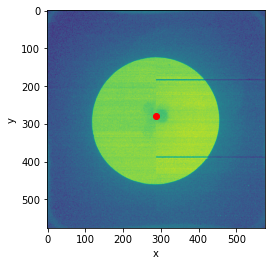

In [5]:
# Calculate a summed diffraction pattern
dp = sa_crop[::1, ::1, :, :].sum(axis=(0, 1))

# Set the center of the pattern
center = stim.com_dense(dp) # center of intensity
center = (288, 280) # manual
print('Center of pattern at {0[0]}, {0[1]}'.format(center))

fg,ax = plt.subplots(1,1)
ax.imshow(dp, norm=PowerNorm(0.25))
_ = ax.scatter(center[0], center[1], c='r')
ax.set(xlabel='x',ylabel='y');

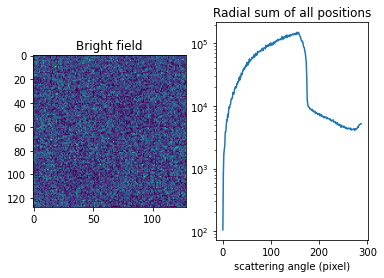

In [6]:
# Radial sum the sparse data
bf_outer_angle = 10
radial_sum = stim.radial_sum_sparse(sa_crop, center=center) # here center is (col, row)
bf = radial_sum[:, :, 0:bf_outer_angle].sum(axis=2)

fg,ax = plt.subplots(1, 2)
ax[0].imshow(bf)
ax[0].set(title='Bright field')
ax[1].plot(radial_sum.sum(axis=((0,1))))
ax[1].set(title='Radial sum of all positions', xlabel='scattering angle (pixel)')
ax[1].set_yscale('log')


interactive(children=(IntRangeSlider(value=(0, 50), description='VDF:', max=288), Output()), _dom_classes=('wi…

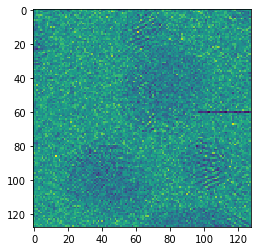

In [7]:
# Create interactive plot for BF and ADF images
fg1, ax1 = plt.subplots(1,1,figsize=(4, 4))
imax1 = ax1.imshow(radial_sum[:, :, 0:50].sum(axis=2), interpolation='none') # Set the initial image and intenstiy scaling 

def axUpdate(i):
    '''updates the plot'''
    s = np.sum(radial_sum[:,:,i[0]:i[1]],axis=2)
    imax1.set_data(s)
    #imax1.set_clim(s[10:-10,10:-10].min(),s.max())
    imax1.set_clim(s[10:-10,10:-10].min(),s[10:-10,10:-10].max())

w1 = widgets.IntRangeSlider(
    value=[0, 50],
    min=0,
    max=288,
    step=1,
    description='VDF:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

interactive(axUpdate, i=w1)